In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.plotting import *
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
from decode_fish.engine.microscope import Microscope
from decode_fish.engine.model import UnetDecodeNoBn
import shutil
from torch.utils.tensorboard import SummaryWriter
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.engine.gmm_loss import PointProcessGaussian

from decode_fish.funcs.visualization import *
import ipyvolume as ipv

base_path =  '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/'

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

# Training

Load base config

In [574]:
cfg = OmegaConf.load('config/train.yaml')

Make dataset specific changes

In [575]:
cfg.output.project = 'N2_352'

cfg.run_name ='N2_352_b9'
cfg.data_path.image_path = base_path + '/datasets/CodFish/N2_352-1.tif'
cfg.data_path.psf_path = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/N2_352/sweep_b15/lr:0.0005xpsf_noise:2e-05/psf.pkl'
cfg.ground_truth = None
cfg.PSF.psf_extent_zyx = [21,21,21]

cfg.evaluation.txt_path = None
cfg.evaluation.crop_sl = 's_[:,200:250,150:200,:]'
cfg.evaluation.px_size =  [100,100,100]

cfg.foci.n_foci_avg = 2
cfg.microscope.psf_noise = 5e-4
cfg.microscope.multipl = 60
cfg.pointprocess.min_int = 0.15

cfg.autoencoder.opt.lr = 0 #1e-5
cfg.autoencoder.norm_reg = 1

# cfg.PSF.gauss_radii = [1.5,1,1]

In [576]:
OmegaConf.save(cfg, f'config/experiment/{cfg.run_name}.yaml')

In [826]:
cfg = OmegaConf.load('config/experiment/N2_352_b8.yaml')
cfg.run_name ='N2_352_b12'
cfg.supervised.num_iter = 0
cfg.autoencoder.step_size = 2000

cfg.autoencoder.opt.lr = 5e-4
cfg.microscope.psf_noise = 2e-5
cfg.autoencoder.grad_clip = 0.1
cfg.autoencoder.norm_reg = 0.5
cfg.autoencoder.opt._target_ = 'torch.optim.SGD'
cfg.autoencoder.opt.momentum = 0
# cfg.autoencoder.l1_decay = 0
cfg.other.pp = 'isi'

cfg.data_path.model_init = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/N2_352/nb_run/N2_352_b8/sl_save'
OmegaConf.save(cfg, f'config/experiment/{cfg.run_name}.yaml')

In [735]:
# print(OmegaConf.to_yaml(cfg))

Store the config as an experiment

In [12]:
img_3d, decode_dl = get_dataloader(cfg)
psf, noise, micro = load_psf_noise_micro(cfg)

Plot projections of the volume

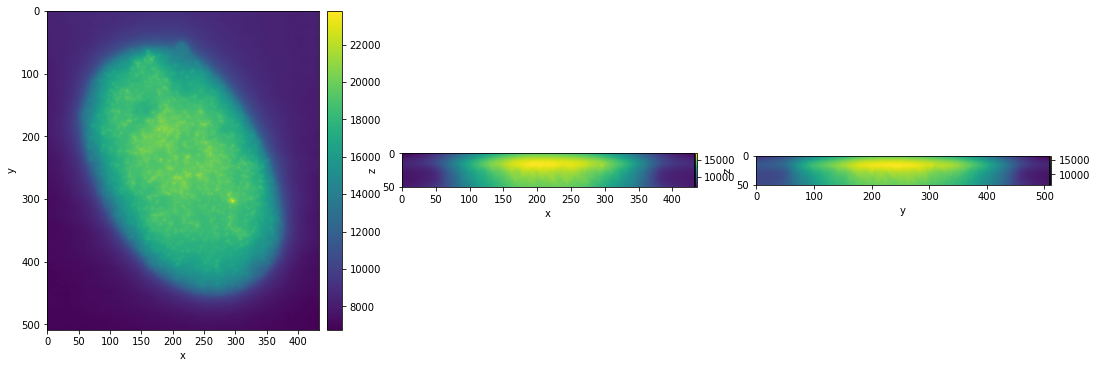

In [13]:
_ = plot_3d_projections(img_3d)

Plot a sample from our dataloader showing a slice from the input volume and from a simulated training volume

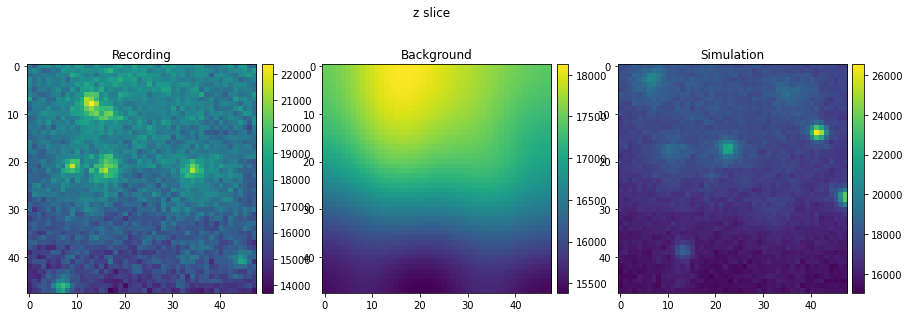

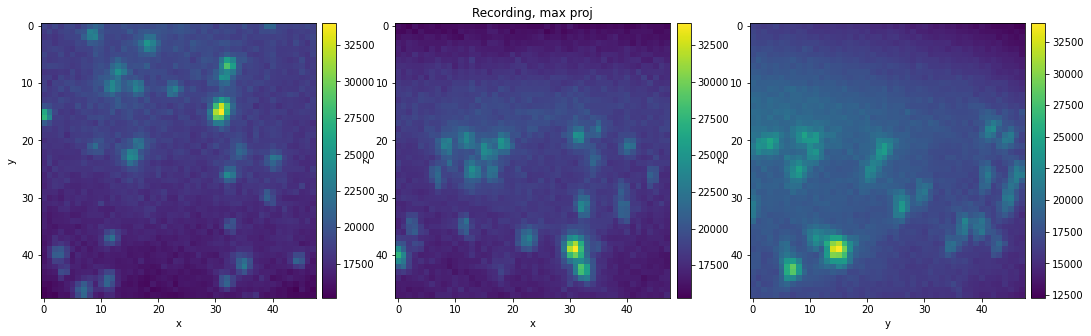

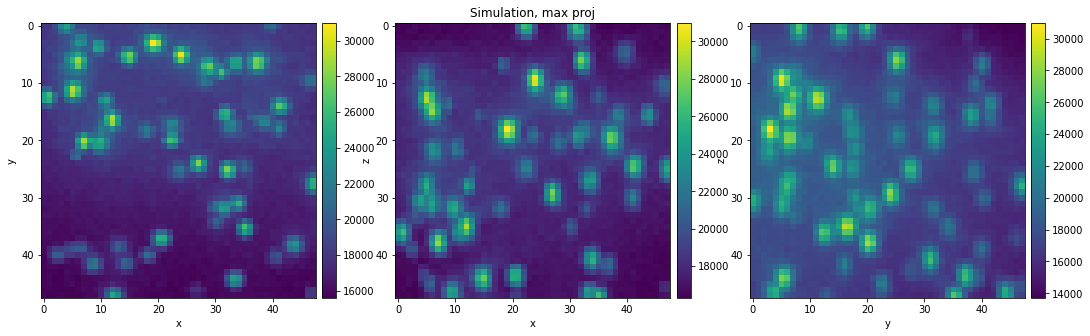

In [834]:
get_simulation_statistics(decode_dl, micro, int_threshold=2000)

Command to train a model on the gpu cluster

In [557]:
home_dir = os.getenv("HOME")
f'bsub -gpu "num=1" -q gpu_any -o {home_dir}/logs/ofish.log -e {home_dir}/logs/efish.log {home_dir}/anaconda3/envs/decode2_dev/bin/python {home_dir}/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment={cfg.run_name}'

'bsub -gpu "num=1" -q gpu_any -o /groups/turaga/home/speisera/logs/ofish.log -e /groups/turaga/home/speisera/logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode2_dev/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment=N2_352_b9'

# Evaluation

In [827]:
# cfg = OmegaConf.load(f'config/experiment/N2_352_b10.yaml')
# exp_dir = 'N2_7/'
exp = 'norm_reg:0.51'
# cfg = OmegaConf.load('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/N2_352/nb_run/N2_352_b10/train.yaml')
# cfg = OmegaConf.load('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/N2_352/sweep_b14/lr:5e-05xmomentum:0.0/train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/N2_352/sweep_b19/{exp}/train.yaml')
# cfg = OmegaConf.load('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/N2_352/sweep_5/psf_noise:0/train.yaml')
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/N2_352//autoencoder.lr:5e-05/train.yaml')
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/N2_3/autoencoder.lr:5e-05/train.yaml')

In [828]:
# cfg.output.save_dir = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/N2_352/nb_run/N2_352_b10/'

In [829]:
path = Path(cfg.output.save_dir)
# path = Path('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/N2_352/nb_run/N2_352_b8/sl_save')
# cfg.microscope.psf_noise = 0
model = hydra.utils.instantiate(cfg.model)
model = load_model_state(model, path, 'model.pkl')
psf_init, noise, micro = load_psf_noise_micro(cfg)
psf_init.load_state_dict(torch.load(path/'psf_init.pkl'))
psf_init.cuda()
# post_proc = load_post_proc(cfg)
post_proc = hydra.utils.instantiate(cfg.post_proc_isi, samp_threshold=0.5)
psf, noise, micro = load_psf_noise_micro(cfg)
psf.load_state_dict(torch.load(path/'psf.pkl'))
psf.cuda()

LinearInterpolatedPSF()

Plot projections of the PSF before and after optimizing it during training

array([<AxesSubplot:xlabel='x', ylabel='y'>,
       <AxesSubplot:xlabel='x', ylabel='z'>,
       <AxesSubplot:xlabel='y', ylabel='z'>], dtype=object)

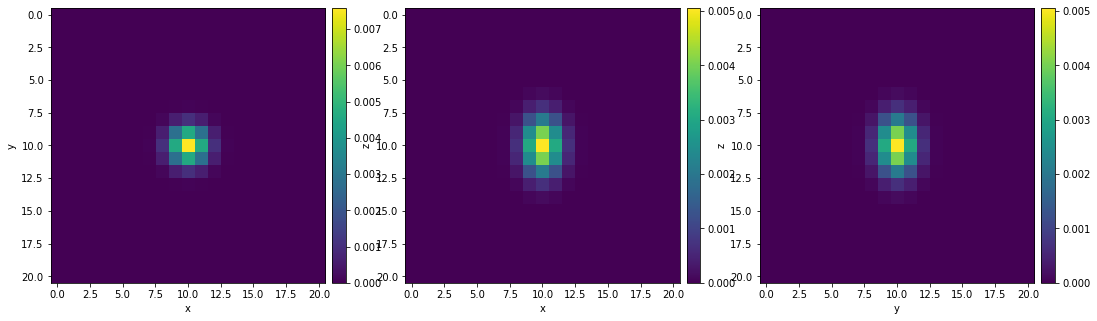

In [830]:
plot_3d_projections(psf_init.psf_volume[0])

tensor(1.0003, device='cuda:0', grad_fn=<SumBackward0>)

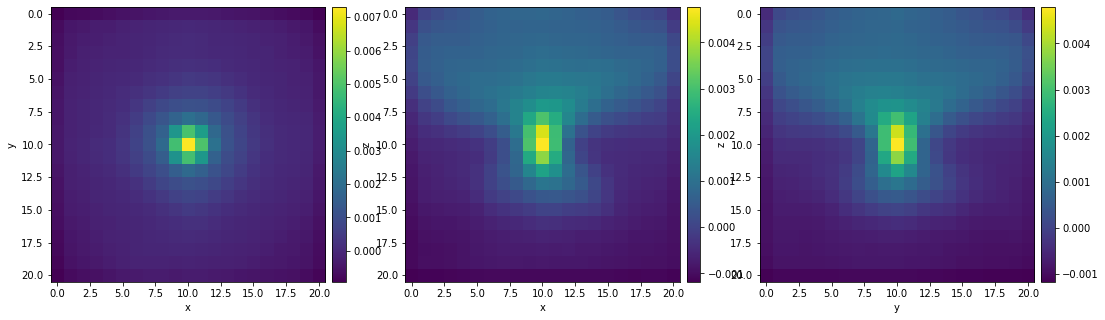

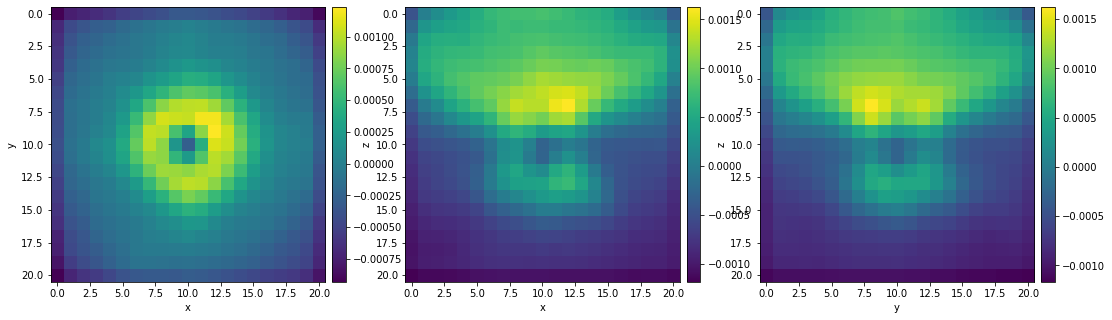

In [831]:
plot_3d_projections(psf.psf_volume[0])
plot_3d_projections(psf.psf_volume[0]-psf_init.psf_volume[0], 'mean')
psf.psf_volume[0].sum()

Sample random sub volumes and overlay them with predictions, also show the reconstructions from applying the microscope and psf model to those predictions

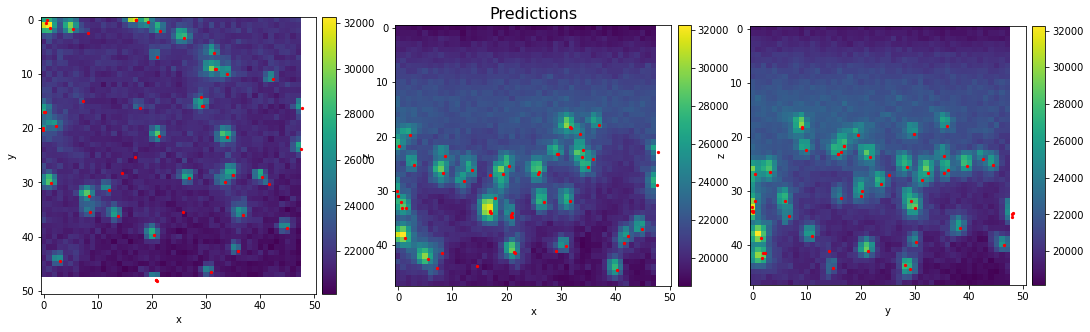

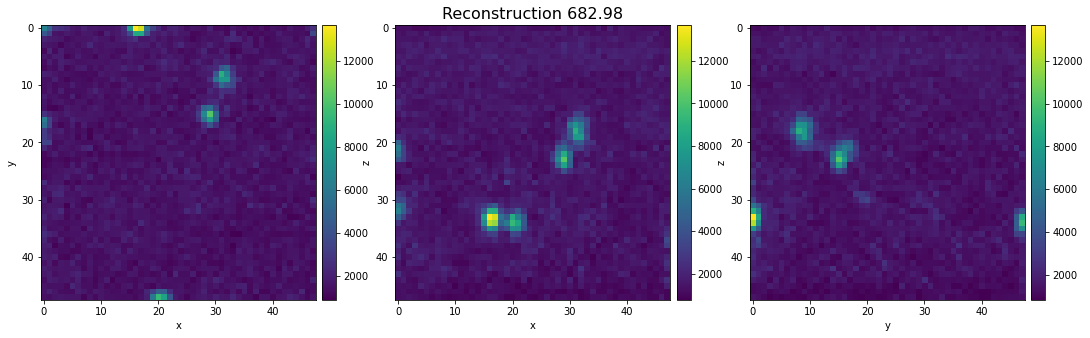

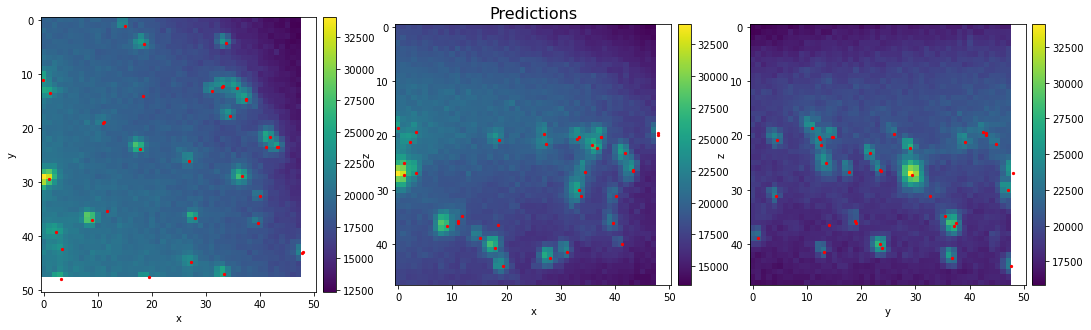

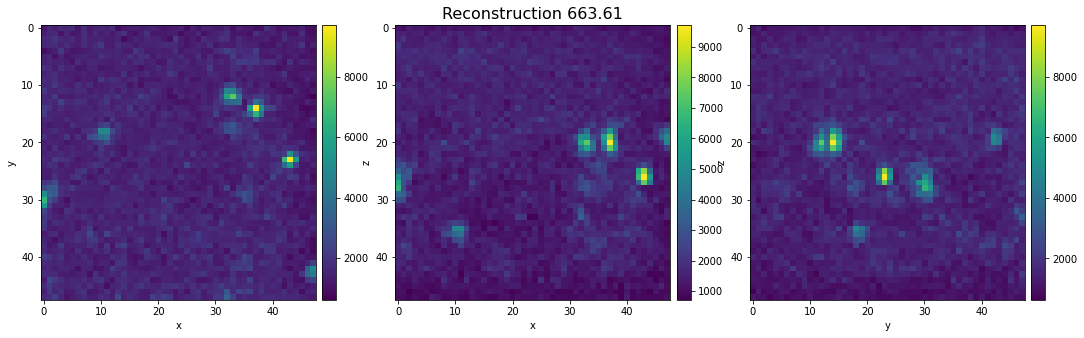

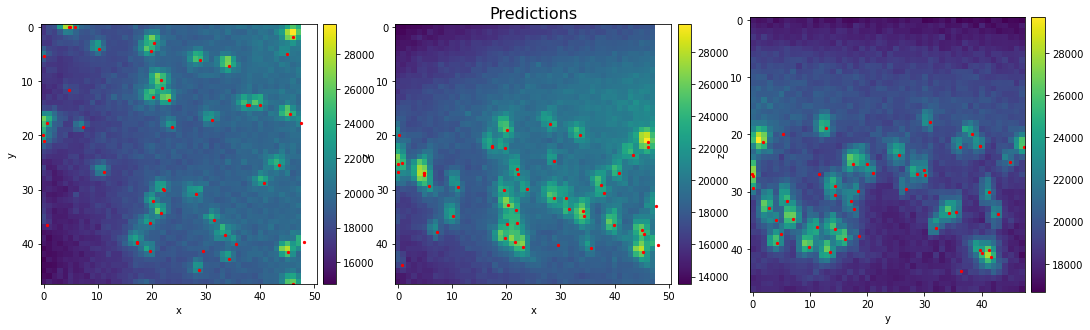

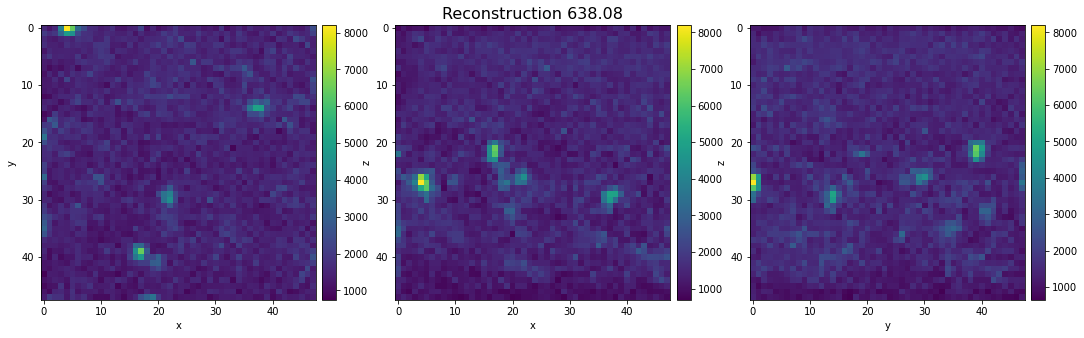

In [832]:
eval_random_crop(decode_dl, model, post_proc, micro, projection='max', samples=3)

Volume with Foci? Max projection of real volume, reconstruction, difference

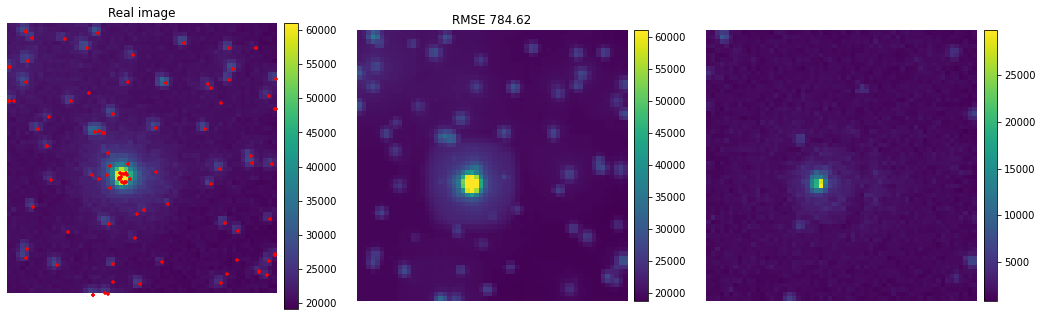

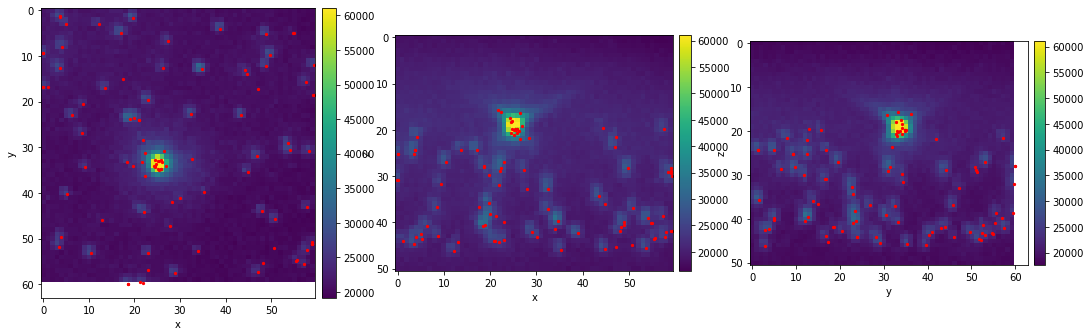

In [835]:
pred_df, gt_rec, res_dict = get_prediction(model,post_proc,img_3d[:,270:330,270:330], micro, return_rec=True, cuda=True)
axes = gt_plot(img_3d[:,270:330,270:330][None], pred_df, gt_df=None, px_size=[100,100,100], gt_rec=gt_rec[0])
torch.save(res_dict, 'data/model_output_r.pt')
len(pred_df)
pred_df = nm_to_px(pred_df)
axes = plot_3d_projections(img_3d[:,270:330,270:330], 'max')
axes[0].scatter(pred_df['x'],pred_df['y'], color='red', s=5.)
axes[1].scatter(pred_df['x'],pred_df['z'], color='red', s=5.)
axes[2].scatter(pred_df['y'],pred_df['z'], color='red', s=5.)

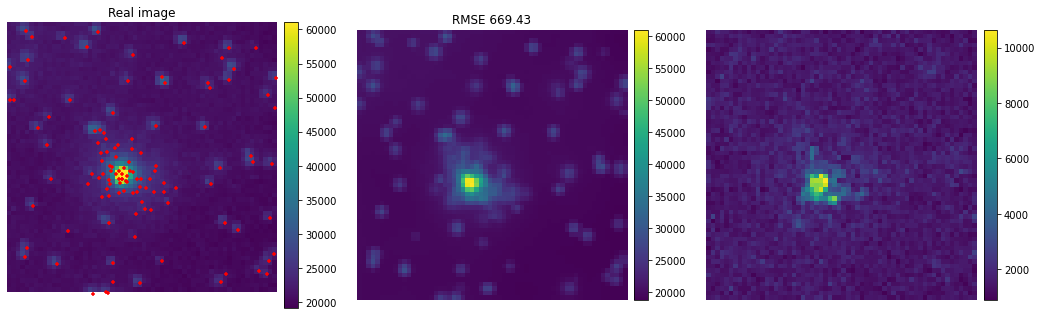

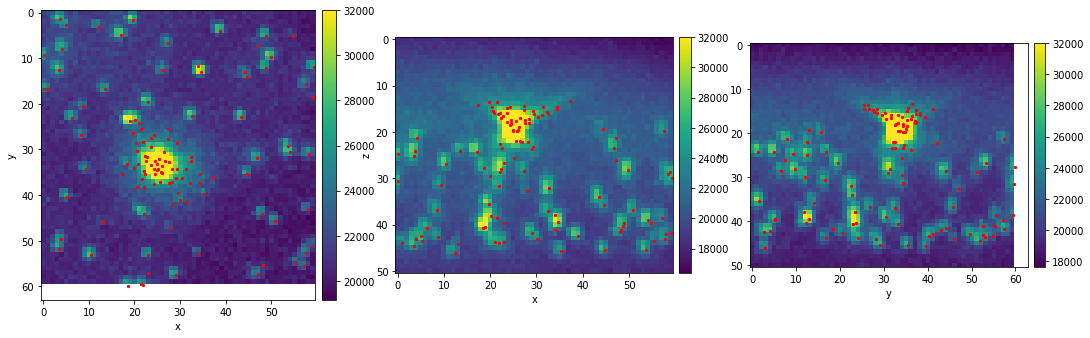

In [792]:
pred_df, gt_rec, res_dict = get_prediction(model,post_proc,img_3d[:,270:330,270:330], micro, return_rec=True, cuda=True)
axes = gt_plot(img_3d[:,270:330,270:330][None], pred_df, gt_df=None, px_size=[100,100,100], gt_rec=gt_rec[0])
torch.save(res_dict, 'data/model_output_r.pt')
len(pred_df)
pred_df = nm_to_px(pred_df)
axes = plot_3d_projections(img_3d[:,270:330,270:330], 'max', vmax=32000)
axes[0].scatter(pred_df['x'],pred_df['y'], color='red', s=5.)
axes[1].scatter(pred_df['x'],pred_df['z'], color='red', s=5.)
axes[2].scatter(pred_df['y'],pred_df['z'], color='red', s=5.)

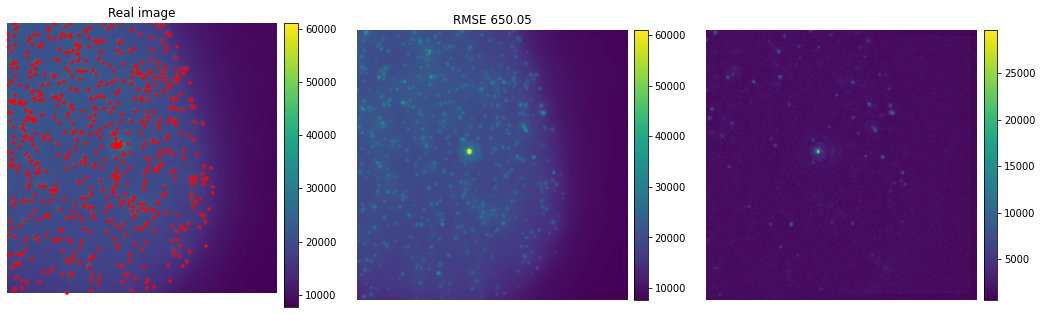

In [825]:
pred_df, gt_rec, _ = get_prediction(model,post_proc,img_3d[:,200:430,200:430], micro, return_rec=True, cuda=True)
_ = gt_plot(img_3d[:,200:430,200:430][None], pred_df, gt_df=None, px_size=[100,100,100], gt_rec=gt_rec[0])

In [697]:
cfg.prob_generator.high = 0.003
cfg.foci.n_foci_avg = 0
cfg.dataloader.bs=1
psf, noise, micro = load_psf_noise_micro(cfg)
psf.load_state_dict(torch.load(Path(cfg.output.save_dir)/'psf.pkl'))
img_3d, decode_dl = get_dataloader(cfg)

In [495]:
def sim_data(decode_dl, batches):
    
    gt_dfs = []
    xsim_col = []
    
    for _ in range(batches):
        x, local_rate, background = next(iter(decode_dl))
        sim_vars = PointProcessUniform(local_rate, min_int=decode_dl.min_int).sample()
        xsim = micro(*sim_vars)
        x = micro.noise(xsim, background).sample()
        
        xsim_col.append(x)
        gt_dfs.append(sample_to_df(*sim_vars[:-1]))
        
    return torch.cat(xsim_col), cat_emitter_dfs(gt_dfs)

def get_sim_perf(x, gt_df, model, post_proc, micro, cuda=True, print_res=True):

    pred_dfs = []
    x_recs = []
    
    for i in range(len(x)):
        
        pred_df, rec, res_dict = get_prediction(model, post_proc, x[i:i+1], micro=micro, cuda=True, return_rec=True)
        pred_dfs.append(pred_df)
        x_recs.append(rec)
        
    pred_df = cat_emitter_dfs(pred_dfs)
    xrec = torch.cat(x_recs)
    perf, matches, _ = matching(gt_df, pred_df, tolerance=500, print_res=print_res)
    perf['mae'] = abs(xrec-rec).mean().item()
    perf['rmse'] = torch.sqrt(((xrec-rec)**2).mean()).item()
    
    return perf, pred_df

In [501]:
xsim, gt = sim_data(decode_dl, 10)

In [507]:
post_proc1 = SIPostProcess(m1_threshold=0.03, m2_threshold=0.6, samp_threshold=0.1, px_size=[100,100,100], diag=False)
post_proc2 = ISIPostProcess(m1_threshold=0.03, samp_threshold=0.5, px_size=[100,100,100], diag=True)

In [508]:
perf, pred_df = get_sim_perf(xsim, gt, model, post_proc1, micro, print_res=True)

Recall: 0.838
Precision: 1.000
Jaccard: 83.742
RMSE_vol: 16.973
Eff_3d: 81.660
FN: 510.0 FP: 1.0
Shift: -0.91,0.76,-0.67


In [512]:
post_proc2 = ISIPostProcess(m1_threshold=0.03, samp_threshold=0.6, px_size=[100,100,100], diag=True)
perf, pred_df = get_sim_perf(xsim, gt, model, post_proc2, micro, print_res=True)

Recall: 0.930
Precision: 0.990
Jaccard: 92.116
RMSE_vol: 43.735
Eff_3d: 76.755
FN: 221.0 FP: 29.0
Shift: -1.07,-1.31,0.55


In [ ]:
p1_dicts = []
p2_dicts = []

sweep = np.linspace(0.3,0.7,11)

for m in tqdm(sweep):
    post_proc1.m2_threshold = m
    p1_dicts.append(get_sim_perf(xsim, gt, model, post_proc1, micro, print_res=False)[0])

sweep = np.linspace(0.1,0.7,11)

for m in tqdm(sweep):
    post_proc2.samp_threshold = m
    p2_dicts.append(get_sim_perf(xsim, gt, model, post_proc2, micro, print_res=False)[0])

 73%|███████▎  | 8/11 [01:53<00:42, 14.14s/it]

In [ ]:
# x,_,_ = next(iter(decode_dl))

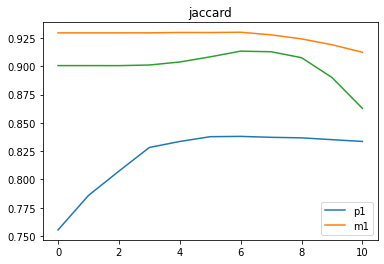

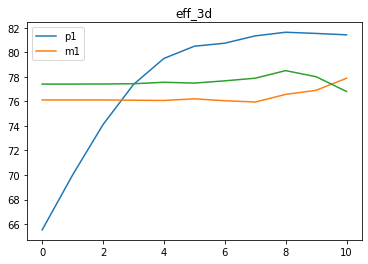

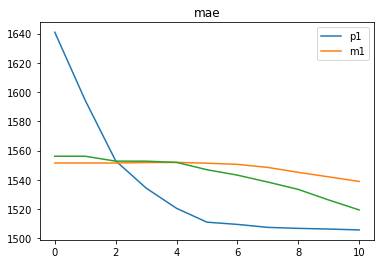

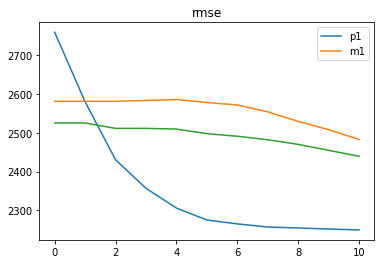

In [506]:
metrics = ['jaccard','eff_3d','mae','rmse']
for m in metrics:
    y = [d[m] for d in p1_dicts]
    plt.plot(y, label='p1')
    y = [d[m] for d in p2_dicts]
    plt.plot(y, label='m1')
    y = [d[m] for d in p3_dicts]
    plt.plot(y)
    plt.title(m)
#     plt.ylim(80,95)
    plt.legend()
    plt.show()

In [27]:
with torch.no_grad():
    model.cpu()
    res = model(img_3d[None,None])
#     res = model(x.cpu())
    pred_df1 = post_proc(res)
    free_mem()

Inferred intensities

NameError: name 'pred_df2' is not defined

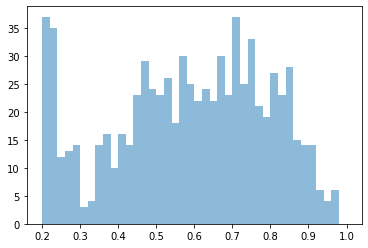

In [29]:
_ = plt.hist(pred_df['int'], bins=np.linspace(0.2,1,41), alpha=0.5)
print(len(pred_df1),len(pred_df2))

In [259]:
def scatter3d_df(df, shape, px_size=[100,100,100], color='red', size=1):
    ipv.scatter(df['x']/px_size[0] - 1/2*shape[2], 
                df['y']/px_size[1] - 1/2*shape[1], 
                df['z']/px_size[2] - 1/2*shape[0], size=size, marker='sphere', color=color)

3D rendering

In [ ]:
vol = img_3d.numpy()

extent = [[-s/2,s/2] for s in vol.shape]
extent = [extent[i] for i in [2,1,0]]

ipv.figure()
ipv.pylab.volshow(vol, level=[.2,0.25,.1], opacity=[0.04,0.2,0.01], extent=extent)
scatter3d_df(pred_df, vol.shape, [100.,100.,300.], 'black', size=0.5)
ipv.xyzlim(max(vol.shape)/2)
ipv.view(90, 40)
ipv.show()